# Is Football Fair?

Good question, isn't it? Seeing how Real Madrid wins their Champions League trophies (yes, I am a Barcelona fan) one might think it is not fair at all. Also, knowing that the game is low-scoring and luck plays quite a role in it, one might get to the same conclusion - the game isn't fair at all.

But what do we mean by calling a game fair? In the end, if the team won, they fought for it, they deserved the victory and this victory is fair for them. From the other side, we have seen a lot of lucky goals or unfortunate errors that led to goals that made a decisive turn in the game. If favourite always wins - is it fair? Probably. But it is not that fun. From the other side, when outsider wins, is this fair?

I guess the right answer will always be "it depends". It depends on an effort that a team put into their victory. If the team plays well and wins it is fair, correct? If the team can't even make a shot on the opponent's goal and loses, it is also fair, correct?

Another story is when a team plays incredibly well, creates moments, attacks. but cannot score, while the opponent makes one shot, scores one goal and wins. This is totally unfair. These days we have the possibility to evaluate an effort that team made in every particular game and see if th result of that effort was fair.

xG metric shows us an expected goal value for every shot in the game and usually it is a great indicator of an amount of moments the team created to score a goal. 

I have found a dataset with xG metrics for every game in the last few years in 40 different football leagues. More about where and how I got that data [here](https://medium.com/geekculture/scraping-xg-data-for-almost-any-league-in-the-world-9e9ddcc2a339?sk=3e422d47b778038eaab6bab7150dad7b).


## Plan of action
So, if the team created enough moments to score 2 goals and scored 2 - it is fair. If their opponent created moments for 1 goal and scored 1, the final result should've been 2-1 and the first team should have won. That's what we will call fair. We have to calculate the amount of games that ended up 'fairly' - if the xG of one team is bigger than the xG of another, the result has to be the victory of the first team. The same goes for draws - both teams created moments for 1 goals each, then draw is a fair result.

*Note:* Obviously, the time of goal scoring is important in football, who scores first too, and many-many other factors. I am not pretending to be the judge of fairness, just a simple general look into data for a lot of games to see some basic trends.

In the perfect and fair world if we were to compare xG results with actual results the compatibility should have been 100%, which means that all the games that ended up with one result or another based on xG, ended up the same in reality. Also, in such a world unicorns could have been possible.

Let's assume that if 90% of the games won/drawn/lost by xG in reality ended up with the same result, we can call football fair. This number, 90%, is taken out of nothing and is subject to discussions. Also, probably, it might make sense to calculate this 'coefficient of fairness' in basketball and then apply it to football. As basket is a high-scoring game, the influence of luck is quite reduced here, meaning that normally a stronger team will win. Finding out the percentage of games that end up with xg_result=actual_result will create a benchmark for this 'coefficient of fairness'. Maybe that's a topic fo the next article. At the moment lets use the 90% benchmark.


## Process

Let's import standard data manipulation libraries and get our data.

In [14]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import matplotlib.pyplot as plt

In [15]:
URL = 'https://projects.fivethirtyeight.com/soccer-api/club/spi_matches.csv'

data = pd.read_csv(URL)

Checking the columns in our dataset.

In [16]:
data.columns

Index(['season', 'date', 'league_id', 'league', 'team1', 'team2', 'spi1',
       'spi2', 'prob1', 'prob2', 'probtie', 'proj_score1', 'proj_score2',
       'importance1', 'importance2', 'score1', 'score2', 'xg1', 'xg2', 'nsxg1',
       'nsxg2', 'adj_score1', 'adj_score2'],
      dtype='object')

We won't need the majority of this columns, so we select only those we are interested in: 'season', 'date', 'league', 'team1', 'team2', 'score1', 'score2', 'xg1', 'xg2'. At the same time we drop all the rows with null values in this modified dataset as we cannot use them at all.

In [17]:
# championship = data[data['league'] == 'English League Championship']
data = data[['season', 'date', 'league', 'team1', 'team2', 'score1', 'score2', 'xg1', 'xg2']]
data = data.dropna()

`describe()` method is an excelent way to quickly get an idea of what kind of data we have here. As we can see, the analysis will be based on 29659 games from different countries and different levels of leagues, with the data from 2016 to 2022. We can also see that record amount of goals is 13 during this period of time, while the maximum xG is 8.27 (and it has yet to be confirmed if that happened in the same game).

In [18]:
data.describe().round(2)

,season,score1,score2,xg1,xg2
count,29659.00,29659.00,29659.00,29659.00,29659.00
mean,2018.94,1.52,1.19,1.49,1.19
std,1.64,1.27,1.14,0.83,0.74
min,2016.00,0.00,0.00,0.00,0.00
25%,2018.00,1.00,0.00,0.88,0.63
50%,2019.00,1.00,1.00,1.36,1.05
75%,2020.00,2.00,2.00,1.96,1.59
max,2022.00,10.00,13.00,7.07,8.27


Well, OK. That happened in the same game.

In [19]:
data[data['xg2'] > 8]

,season,date,league,team1,team2,score1,score2,xg1,xg2
35662,2020,2020-10-24,Dutch Eredivisie,VVV Venlo,Ajax,0.0,13.0,0.23,8.27


As dataset do not give us a column `'result'` we will calculate it on our own. The same will be done for the column `'xg_result'` only with a little tweak - rounding to the integer, because without it the draws are impossible. Yes, rounding may distort a result somehow, but as was stated before, this article is not pretending to be published in science journal, just amateur playing around with numbers. 

To create these columns `np.select` is a perfect tool for the job.

In [20]:
conditions = [
    (data['score1'] > data['score2']),
    (data['score1'] == data['score2']),
    (data['score1'] < data['score2'])
]
values = ['1', 'X', '2'] # home_win, draw, away_win
data['result'] = np.select(conditions, values)

In [21]:
xg_conditions = [
    (data['xg1'].round(0) > data['xg2'].round(0)),
    (data['xg1'].round(0) == data['xg2'].round(0)),
    (data['xg1'].round(0) < data['xg2'].round(0))
]
xg_values = ['1', 'X', '2'] # home_win, draw, away_win
data['xg_result'] = np.select(xg_conditions, xg_values)

We take a look at our data and we already see that results do not match in 4 cases out of 5. But this selection isn't representative, we have to check out at all the games.

In [22]:
data.head()

,season,date,league,team1,team2,score1,score2,xg1,xg2,result,xg_result
10,2016,2016-08-12,French Ligue 1,Bastia,Paris Saint-Germain,0.0,1.0,0.97,0.63,2,X
11,2016,2016-08-12,French Ligue 1,AS Monaco,Guingamp,2.0,2.0,2.45,0.77,X,1
12,2016,2016-08-13,Barclays Premier League,Hull City,Leicester City,2.0,1.0,0.85,2.77,1,2
13,2016,2016-08-13,Barclays Premier League,Everton,Tottenham Hotspur,1.0,1.0,0.73,1.11,X,X
14,2016,2016-08-13,Barclays Premier League,Crystal Palace,West Bromwich Albion,0.0,1.0,1.11,0.68,2,X


If we go directly and ask a question "How many games ended with the actual result distinct from the xG one?", we find that this number is quite big - 14310 out of 29659

In [26]:
data[data['xg_result'] != data['result']].count()[0]

14310

Or we can say that 48.25% of the games do not end up the same as it should (according to xG metric)

In [31]:
f"{data[data['xg_result'] != data['result']].count()[0]/data.count()[0]*100:.2f}%"

'48.25%'

That seems quite unfair. But as we know there are 3 different outcomes in each football game: victory, draw and defeat. So let's compare how many times teams won and should have won, drew and should have drawn, lost and should have lost.

To do this we will create an abstract dataset of results and xg_results and see how these two sets of values differ.

In [32]:
results = data[['result', 'xg_result']]

In [33]:
results['xg_result'].value_counts()

1    12755
X     9847
2     7057
Name: xg_result, dtype: int64

In [34]:
results['result'].value_counts()

1    13289
2     8784
X     7586
Name: result, dtype: int64

And now let's put these values in a bar chart next to each other.

([<matplotlib.axis.XTick at 0x7f822a759e50>,
 [Text(0, 0, '1'), Text(1, 0, 'X'), Text(2, 0, '2')])

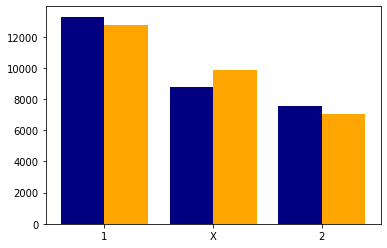

In [44]:
x = ['1', 'X', '2']
scores = results['result'].value_counts().values
xg_scores = results['xg_result'].value_counts().values
  
X_axis = np.arange(len(x))
  
plt.bar(X_axis - 0.2, scores, 0.4, label = 'Scores', color='navy')
plt.bar(X_axis + 0.2, xg_scores, 0.4, label = 'xG_scores', color='orange')
plt.xticks(np.arange(3), ['1', 'X', '2'])


And what we can see visually is that there is no such a huge difference between actual outcomes and expected ones. And if we put this into numbers we get:

In [56]:
diffs = list(np.divide(scores, xg_scores))

for diff in diffs:
    print(f'{x[diffs.index(diff)]}: {abs(1-diff)*100:.2f}%')

1: 4.19%
X: 10.80%
2: 7.50%


It means that when we compare the amount of games that ended up in the victory of home team in reality, we can see that this number differs from expected xG_result only in 4.19% of occasions, draws differ in 10.80% of occasions, and victories of away teams - in 7.5%. So, apparently, football IS fair?

## Conclusion

I will be honest here, I've got a bit confused in the end and not sure if the steps I took are correct. I am not trying to manipulate data consciously, but maybe I am making an error by comparing the datapoints in a wrong way.

Anyway, what my conclusion is the following: we can claim that football is quite fair game as stronger team usually wins against weaker one. And even though the actual results of every particular game might not correspond to the expected ones, on the global scale, when we talk big numbers, we can see that the distribution of real outcomes and expected ones are quite similar, therefore the conclusion that football is fair makes sense (taking into account our benchmark of 90% of same outcomes or 10% of different outcomes)  